In [1]:
!pip install patchify albumentations  > /dev/null 
!pip install -q -U segmentation-models > /dev/null 
!pip install --upgrade git+https://github.com/divamgupta/image-segmentation-keras > /dev/null 
%env SM_FRAMEWORK=tf.keras

  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras /tmp/pip-req-build-fu6kts9g
env: SM_FRAMEWORK=tf.keras


In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from patchify import patchify

import utils
import utils_road_buildings as utils_rb
import utils_cityscapes as utils_cs

##### SEGMENTATION MODEL LIBRARY #####
import segmentation_models as sm
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss, DiceLoss, binary_focal_dice_loss, BinaryFocalLoss
from segmentation_models.metrics import iou_score, f1_score, IOUScore, FScore

##### KERAS SEGMENTATION LIBRARY #####
from keras_segmentation.models import segnet
from keras_segmentation.models.model_utils import transfer_weights, get_segmentation_model #molto prob. transfer weight non ci serve.
from keras_segmentation.models.vgg16 import get_vgg_encoder
from keras_segmentation.models.resnet50 import get_resnet50_encoder


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Reshape, Convolution2D, BatchNormalization

Segmentation Models: using `tf.keras` framework.


In [3]:
from tensorflow.keras import backend as K

def vgg_segnet(input_shape=(256, 256), channels=3, freeze_weight = True, n_labels=2):
    encoder = get_vgg_encoder # get_resnet50_encoder
    img_input, levels = encoder(input_height=input_shape[0],  input_width=input_shape[1], channels=channels)
    feat = levels[4]
    o = segnet.segnet_decoder(feat, n_labels, n_up=5)
    model = get_segmentation_model(img_input, o)
    model.model_name = "vgg.segnet"
    
    if freeze_weight == True:
        for i in range(20):
            model.layers[i].trainable = False
    return model

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred, alpha=1):
    return 1 - tversky(y_true, y_pred, alpha=alpha)


def focal_tversky_loss(y_true, y_pred, gamma=0.75, alpha=1):
    tv = tversky(y_true, y_pred, alpha=alpha)
    return K.pow((1 - tv), gamma)

vgg16_preprocessing = sm.get_preprocessing('vgg16')

# Massachusetts Buildings

In [ ]:
DATA_DIR = '../input/massachusetts-buildings-dataset/tiff/'
PATCH_HEIGHT = 500
PATCH_WIDTH = 500

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

# [0, 0, 0] -> background [255, 255, 255] -> Buldings

class_dict = pd.read_csv("../input/massachusetts-buildings-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels: ')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)
b_train_img_paths, b_train_msk_paths = utils.get_images_paths(x_train_dir, y_train_dir)
b_valid_img_paths, b_valid_msk_paths = utils.get_images_paths(x_valid_dir, y_valid_dir)
b_test_img_paths, b_test_msk_paths = utils.get_images_paths(x_test_dir, y_test_dir)

In [ ]:
trans_aug_fn = utils.get_training_augmentation(prob=0.5)
train_images, train_masks = utils.load_preprocess_images(b_train_img_paths, b_train_msk_paths, (PATCH_WIDTH, PATCH_HEIGHT), (256,256), 2, class_rgb_values, trans_aug_fn)
train_images = np.array(train_images)
train_images = vgg16_preprocessing(train_images)
train_masks = np.array(train_masks)

val_images, val_masks = utils.load_preprocess_images(b_valid_img_paths, b_valid_msk_paths, (PATCH_WIDTH, PATCH_HEIGHT), (256,256), 2, class_rgb_values)
val_images = np.array(val_images)
val_masks=np.array(val_masks)
val_images = vgg16_preprocessing(val_images)

In [ ]:
# set the parameters
batch_size = 32
n_epochs = 15
n_labels = 2
input_shape = (256, 256, 3)

def weighted_bce(y_true, y_pred):
    weights = (y_true * 3.) + 1.
    bce = keras.backend.binary_crossentropy(y_true, y_pred)
    weighted_bce = keras.backend.mean(bce * weights)
    return weighted_bce

loss = focal_tversky_loss
#optimizer = keras.optimizers.SGD(1e-1, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adam(1e-3)


In [ ]:
model = vgg_segnet(freeze_weight = True, n_labels=2)
new_model = keras.Sequential()
new_model.add(model)
new_model.add(keras.layers.Reshape((256,256, 2), input_shape=(65536, 2)))

In [ ]:
new_model.compile(loss=loss, optimizer=optimizer, metrics=[IOUScore(),  FScore() ,tversky])

In [ ]:
#dir_weights = '../input/buildingweights'
#new_model.load_weights(f'{dir_weights}/NewSegNet-bcejaccard-Massachusetts_40_32_Adam_lr_1e-3.h5')

In [ ]:
history = new_model.fit(x=train_images, y=train_masks, batch_size=batch_size, epochs=n_epochs, 
          validation_data=(val_images, val_masks))

In [ ]:
dir_weights='./'
new_model.save_weights(f'{dir_weights}/NewSegNet-tversky-Massachusetts_15_32_Adam_lr_1e-3.h5')
print("save weight done..")

In [ ]:
# print the graph
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [ ]:
test_images_paths, test_masks_paths = utils.get_images_paths(x_test_dir, y_test_dir)
test_images, test_masks = utils.load_preprocess_images(test_images_paths, test_masks_paths, (PATCH_WIDTH, PATCH_HEIGHT), (256, 256), 2, class_rgb_values)
test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_images_real = test_images.copy()
test_images = vgg16_preprocessing(test_images)

In [ ]:
new_model.evaluate(test_images, test_masks)

In [ ]:
pred = new_model.predict(test_images)

In [ ]:
idx = np.random.randint(len(test_images))
#idx=89
utils.visualize(original_image = test_images_real[idx],
                ground_truth = utils.reverse_one_hot(test_masks[idx]),
                pred_mask = utils.reverse_one_hot(pred[idx]))
plt.show()

In [ ]:
# run this cell to save image
utils.visualize(original_image = test_images_real[idx],
                ground_truth = utils.reverse_one_hot(test_masks[idx]),
                pred_mask = utils.reverse_one_hot(pred[idx]))
plt.savefig('SegNet-bcejaccard-Massachusetts_60_32_Adam_lr_1e-3.png')
print('save figure done')

## Road and Building

In [ ]:
mapping_labels = {0: ((0,0,0), [0]), 1: ((255,255,255), [1]), 
                  2: ((255, 0, 0), [2])}
def colour_code_segmentation(image):
    """
    colorization of the segmented image
    """
    w = image.shape[0]
    h = image.shape[1]
    new_img = np.zeros((w,h,3))
    
    for clm in range(h):
        for row in range(w):
            value = int(image[row,clm])
            pixels =  mapping_labels[value][0]  # get ids
            new_img[row,clm,0] = pixels[0]
            new_img[row,clm,1] = pixels[1]
            new_img[row,clm,2] = pixels[2]

    return new_img.astype(int)

def convert_to_single_mask(mask):
    new_mask = np.zeros((mask.shape[0], mask.shape[1]))
    for class_pos in range(mask.shape[2]): 
        tmp = mask[:, :, class_pos].copy()
        tmp [tmp==1] = class_pos
        new_mask = new_mask + tmp
    return new_mask

In [ ]:
DATA_DIR = '../input/massachusetts-roads-dataset/tiff/'
x_r_train_dir = os.path.join(DATA_DIR, 'train')
y_r_train_dir = os.path.join(DATA_DIR, 'train_labels')
x_r_valid_dir = os.path.join(DATA_DIR, 'val')
y_r_valid_dir = os.path.join(DATA_DIR, 'val_labels')
x_b_test_dir = os.path.join(DATA_DIR, 'test')
y_b_test_dir = os.path.join(DATA_DIR, 'test_labels')

road_train_img_paths, road_train_mask_paths = utils.get_images_paths(x_r_train_dir, y_r_train_dir)
road_valid_img_paths, road_valid_mask_paths = utils.get_images_paths(x_train_dir, y_train_dir)
road_test_img_paths, road_test_mask_paths = utils.get_images_paths(x_train_dir, y_train_dir)

(b_train_img_paths, b_train_msk_paths), (road_train_img_paths, road_train_mask_paths) = utils_rb.common_images(b_train_img_paths,
                                                                                                               road_train_img_paths, b_train_msk_paths,
                                                                                                               road_train_mask_paths)

In [ ]:
train_aug_fn = utils.get_training_augmentation(prob=0.5)
x_train, y_train = utils_rb.load_images_masks(b_train_img_paths, b_train_msk_paths, road_train_mask_paths,
                           (PATCH_HEIGHT, PATCH_WIDTH), (256, 256), train_aug_fn)
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train[:, :, :, 0]
y_train = utils_rb.multi_class_mask(y_train)
x_valid = x_train[-200:].copy()
y_valid = y_train[-200:].copy()
x_train = x_train[:-200]
y_train = y_train[:-200]

x_train_sat = x_train.copy()
x_train = vgg16_preprocessing(x_train)
x_valid = vgg16_preprocessing(x_valid)

In [ ]:
batch_size = 12
n_epochs = 20
input_shape = (256,256,3)
#optimizer = keras.optimizers.SGD(1e-1, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adam(1e-3)

In [ ]:
model = vgg_segnet(freeze_weight = True, n_labels=3)
new_model = keras.Sequential()
new_model.add(model)
new_model.add(keras.layers.Reshape((256,256, 3), input_shape=(65536, 3)))

In [ ]:
new_model.compile(optimizer=optimizer, loss=cce_jaccard_loss, metrics=[IOUScore(), FScore()] )

In [ ]:
history = new_model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=n_epochs, 
          validation_data=(x_valid, y_valid))

In [ ]:
new_model.evaluate(x_train, y_train)

In [ ]:
pred = new_model.predict(x_train)
result = np.argmax(pred,axis=-1)

In [ ]:
idx = np.random.randint(len(result))
print(idx)
res_seg = colour_code_segmentation(result[idx]) #colour the mask by using the dictionary, group_label -> pixel
mask_example = y_train[idx]
mask_example = convert_to_single_mask(mask_example) 
result_example = colour_code_segmentation(mask_example)

fig, axes = plt.subplots(1, 3,figsize=(15,15))
_ = axes[0].imshow(x_train_sat[idx])
_ = axes[1].imshow(res_seg)
_ = axes[2].imshow(result_example)
plt.show()

# Cityscapes

In [7]:
DATA_DIR = '../input/cityscape/'

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/annotations')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/annotations')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/annotations')


class_values = utils_cs.grouped_labels
n_labels = len(class_values)+1
BATCH_SIZE = 12
EPOCHS = 40
input_shape = (256,256,3)

#optimizer = keras.optimizers.Adam(1e-1)
optimizer = keras.optimizers.SGD(1e-1,  momentum=0.9)

In [8]:
model = vgg_segnet(freeze_weight = True, n_labels=n_labels)
new_model = keras.Sequential()
new_model.add(model)
new_model.add(keras.layers.Reshape((256,256, n_labels), input_shape=(65536, n_labels)))

new_model.compile(optimizer=optimizer, loss=cce_jaccard_loss, metrics=[IOUScore(),  FScore() ,tversky] )

training_dataset = utils_cs.Dataset(x_train_dir, y_train_dir, class_values=class_values, doreshape=False, preprocessing=utils_cs.get_preprocessing(vgg16_preprocessing))
valid_dataset = utils_cs.Dataset(x_valid_dir, y_valid_dir, class_values=class_values, doreshape=False, preprocessing=utils_cs.get_preprocessing(vgg16_preprocessing))

train_dataloader = utils_cs.Dataloder(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = utils_cs.Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [10]:
# train model
history = new_model.fit(train_dataloader, 
                        epochs=EPOCHS, 
                        validation_data=valid_dataloader
                        )

Epoch 1/40
95/95 [==============================] - 135s 1s/step - loss: 0.7969 - iou_score: 0.3533 - f1-score: 0.4664 - tversky: 0.6720 - val_loss: 0.9194 - val_iou_score: 0.3981 - val_f1-score: 0.4921 - val_tversky: 0.7665
Epoch 2/40
95/95 [==============================] - 133s 1s/step - loss: 0.6690 - iou_score: 0.4496 - f1-score: 0.5726 - tversky: 0.7669 - val_loss: 0.7704 - val_iou_score: 0.4146 - val_f1-score: 0.5134 - val_tversky: 0.7721
Epoch 3/40
95/95 [==============================] - 134s 1s/step - loss: 0.6187 - iou_score: 0.4786 - f1-score: 0.5994 - tversky: 0.7906 - val_loss: 0.7112 - val_iou_score: 0.4157 - val_f1-score: 0.5129 - val_tversky: 0.7876
Epoch 4/40
95/95 [==============================] - 131s 1s/step - loss: 0.6139 - iou_score: 0.4861 - f1-score: 0.6084 - tversky: 0.7933 - val_loss: 0.6955 - val_iou_score: 0.4183 - val_f1-score: 0.5129 - val_tversky: 0.7938
Epoch 5/40
95/95 [==============================] - 131s 1s/step - loss: 0.5927 - iou_score: 0.5029 

In [11]:
dir_weights = './'
new_model.save_weights(f'{dir_weights}/weights-NewSegNet-cityscape_40_12_SGD_lr_1e-3.h5')
print('save weights done')

save weights done


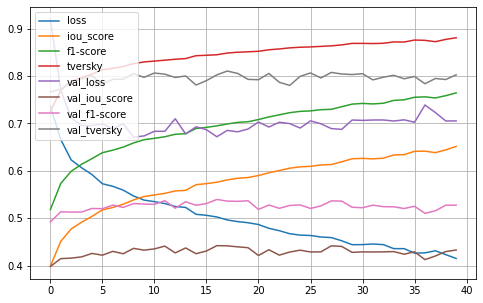

In [12]:
# print the graph
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [13]:
test_dataset = utils_cs.Dataset(x_test_dir, y_test_dir, class_values=class_values, preprocessing=utils_cs.get_preprocessing(vgg16_preprocessing))
test_dataloader = utils_cs.Dataloder(test_dataset, batch_size=1, shuffle=False)

In [14]:
evaluation = new_model.evaluate(test_dataloader)

472/472 [==============================] - 56s 119ms/step - loss: 0.6955 - iou_score: 0.4412 - f1-score: 0.5378 - tversky: 0.8048


In [15]:
pred = new_model.predict(test_dataloader)
result = np.argmax(pred,axis=3)

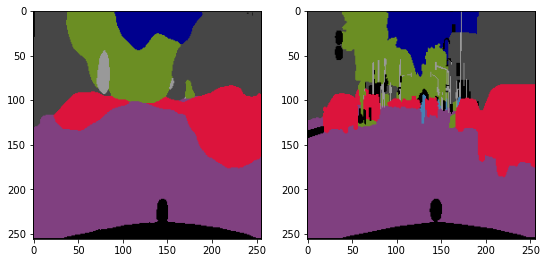

In [22]:
idx = np.random.randint(len(test_dataset))
res_seg = utils_cs.colour_code_segmentation(result[idx]) #colour the mask by using the dictionary, group_label -> pixel

mask_example = test_dataset.__getitem__(idx)[1]
mask_example = test_dataset.convert_to_single_mask(mask_example) 
result_example = utils_cs.colour_code_segmentation(mask_example)

fig, axes = plt.subplots(1, 2,figsize=(9,6))
_ = axes[0].imshow(res_seg)
_ = axes[1].imshow(result_example)
plt.show()